In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"victormayowa","key":"9eb769c3264435da9df1aa59cc650371"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                    title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                        DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           2613        230  1.0              
thedevastator/global-video-game-sales-and-ratings      Global Video Game Sales and Ratings          71KB  2023-12-20 06:46:32           1437         31  0.9411765        
muhammadbinimran/housing-price-prediction-data         Housing Price Prediction Data               763KB  2023-11-21 17:56:32          11686        198  1.0              
thedevastator/film-genre-statistics                    Film Genre Statistics                        36KB  2023-12-19 06:45:48            733     

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 78% 68.0M/86.8M [00:00<00:00, 186MB/s]
100% 86.8M/86.8M [00:00<00:00, 180MB/s]


In [ ]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
import glob
import torch
import torchaudio, torchvision
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
#from torchvision.transforms import transforms
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from PIL import Image

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_data_dir='/content/Training'
test_data_dir = '/content/Testing'

In [ ]:
import os
import random
import shutil

def move_items(source_dir, destination_dir, split_percentage):
    # Create destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # Get a list of items in the source directory
    items = os.listdir(source_dir)

    # Calculate the number of items to move to the validation set
    num_items_to_move = int(len(items) * split_percentage)

    # Randomly select items for the validation set
    validation_set = random.sample(items, num_items_to_move)

    # Move selected items to the validation directory
    for item in validation_set:
        source_path = os.path.join(source_dir, item)
        destination_path = os.path.join(destination_dir, item)
        shutil.move(source_path, destination_path)

In [ ]:
validation_directory = '/content/Validation'
# Set the split percentage (e.g., 25%)
split_percentage = 0.25

# List of tumor types
tumor_types = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Iterate over tumor types
for tumor_type in tumor_types:
    source_path = os.path.join(train_data_dir, tumor_type)
    destination_path = os.path.join(validation_directory, tumor_type)
    move_items(source_path, destination_path, split_percentage)

In [ ]:
images = []
labels = []

classes = os.listdir(train_data_dir)
class_names = classes  # Store the class names

for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_data_dir, class_name)
    for image_name in os.listdir(class_dir):
        images.append(os.path.join(class_name, image_name))
        labels.append(i)

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        classes = os.listdir(data_dir)
        self.class_names = classes  # Store the class names

        for i, class_name in enumerate(classes):
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_name, image_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label
    def get_class_name(self, label):
        return self.class_names[label]

In [ ]:
# Visualize some sample images
sample_dataset = BrainTumorDataset(data_dir=train_data_dir)
sample_loader = DataLoader(sample_dataset, batch_size=4, shuffle=True)

import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(images, labels, dataset):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 3))
    for i, (image, label) in enumerate(zip(images, labels)):
        axs[i].imshow(image)
        class_name = dataset.get_class_name(label)
        axs[i].set_title(f'Class: {class_name}')
        axs[i].axis('off')
    plt.show()


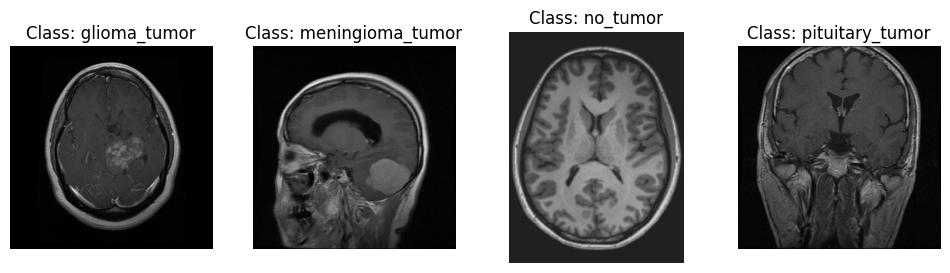

In [ ]:
import random

# Access a few random sample images from the dataset (one from each class)
sample_dataset = BrainTumorDataset(data_dir=train_data_dir)

# Get one random sample from each class
sample_images = []
sample_labels = []

for class_idx in range(len(sample_dataset.class_names)):
    class_samples = [idx for idx, label in enumerate(sample_dataset.labels) if label == class_idx]
    random_sample_idx = random.choice(class_samples)
    sample_images.append(sample_dataset[random_sample_idx][0])
    sample_labels.append(sample_dataset[random_sample_idx][1])

# Visualize the images
show_images(sample_images, sample_labels, sample_dataset)

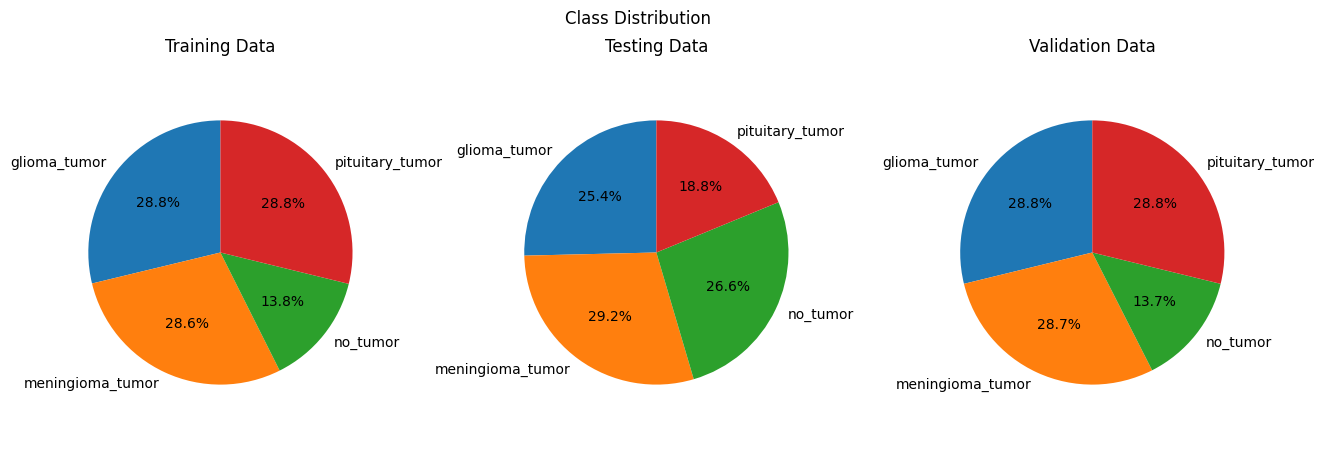

In [ ]:
# Load the dataset and get class counts
train_dataset = BrainTumorDataset(data_dir=train_data_dir)
test_dataset = BrainTumorDataset(data_dir=test_data_dir)
validation_dataset = BrainTumorDataset(data_dir=validation_directory)

train_class_counts = [train_dataset.labels.count(i) for i in range(len(train_dataset.class_names))]
test_class_counts = [test_dataset.labels.count(i) for i in range(len(test_dataset.class_names))]
validation_counts = [validation_dataset.labels.count(i) for i in range(len(validation_dataset.class_names))]

# Create labels for the pie chart
labels = train_dataset.class_names

# Create pie charts with space in between
# Create pie charts with space in between
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0.5})
fig.suptitle('Class Distribution')

ax1.pie(train_class_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('Training Data')

ax2.pie(test_class_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Testing Data')

ax3.pie(validation_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax3.axis('equal')
ax3.set_title('Validation Data')

plt.show()

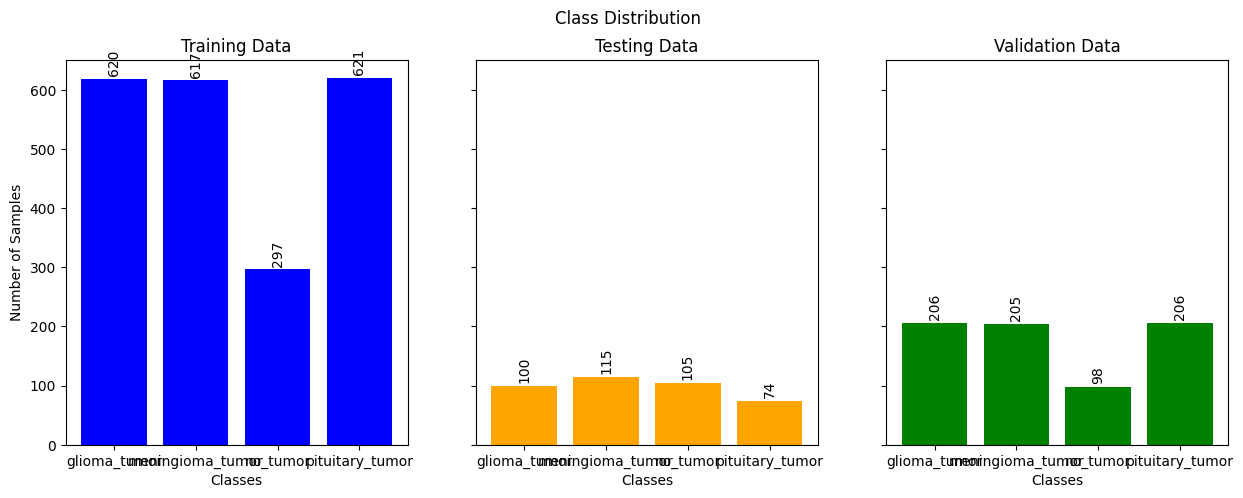

In [ ]:
import seaborn as sns
# Plot bar charts for each dataset
# Plot bar charts for each dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Class Distribution')

# Function to add count labels to each bar
def add_labels(ax, counts):
    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', rotation=90)

ax1.bar(labels, train_class_counts, color='blue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Training Data')
add_labels(ax1, train_class_counts)

ax2.bar(labels, test_class_counts, color='orange')
ax2.set_xlabel('Classes')
ax2.set_title('Testing Data')
add_labels(ax2, test_class_counts)

ax3.bar(labels, validation_counts, color='green')
ax3.set_xlabel('Classes')
ax3.set_title('Validation Data')
add_labels(ax3, validation_counts)

plt.show()

In [ ]:
# Create a list with class distribution data
class_distribution_data = []

for label, train_count, test_count, validation_count in zip(labels, train_class_counts, test_class_counts, validation_counts):
    class_distribution_data.append([label, train_count, test_count, validation_count])

class_distribution_df = pd.DataFrame(class_distribution_data, columns=['Class', 'Train Count', 'Test Count', 'Validation Count'])
class_distribution_df

,Class,Train Count,Test Count,Validation Count
0,glioma_tumor,620,100,206
1,meningioma_tumor,617,115,205
2,no_tumor,297,105,98
3,pituitary_tumor,621,74,206


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# prompt: create  a pytorch  brain mri classifier that can  take a pretrained parameter and directory of dataset
model = models.resnet50(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Sequential(nn.Linear(in_features=model.fc.in_features, out_features=64, bias=True),
        nn.SELU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=64, out_features=64, bias=True),
        nn.SELU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Linear(64, len(class_names)),
        nn.LogSigmoid())
# nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=4096, out_features=4096, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=4096, out_features=4

In [ ]:
for param in model.parameters():
  param.requires_grad = True

In [ ]:
model = model.to(device)

In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_val_loss = 0.0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()

        val_accuracy = correct_val / total_val
        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # Print and visualize
        if epoch % 5 == 0:
          print(f'Epoch {epoch}/{num_epochs}, '
                f'Training Loss: {train_losses[-1]:.4f}, '
                f'Training Accuracy: {train_accuracy:.4f}, '
                f'Validation Loss: {val_losses[-1]:.4f}, '
                f'Validation Accuracy: {val_accuracy:.4f}')

    # Plotting accuracy and loss
    plot_accuracy_loss(range(1, num_epochs + 1), train_accuracies, val_accuracies, train_losses, val_losses)

# Function to plot accuracy and loss
def plot_accuracy_loss(epochs, train_accuracies, val_accuracies, train_losses, val_losses):
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, val_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BrainTumorDataset(data_dir=train_data_dir, transform=train_transform)
val_dataset = BrainTumorDataset(data_dir=validation_directory, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create and train the model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import sys
for epochs in range(1, 10):
  losses = []
  for image, label in train_loader:
    data, label = image.to(device), label.to(device)
    y_hat = model(data)
    print(y_hat.squeeze().shape)
    print(label.shape)
    sys.exit(0)


torch.Size([100, 4])
torch.Size([100])


SystemExit: ignored

In [ ]:
!jupyter notebook --memory-fraction=0.5

In [ ]:
train_model(model, train_loader, val_loader, device, 15, 3e-4)

OutOfMemoryError: ignored

In [ ]:
PATH = os.path.join('/content/','model')
torch.save(model.state_dict(), PATH)

In [ ]:
torch.save(model, '/content/model.pth')

In [ ]:
correct_val = 0
        total_val = 0
        running_val_loss = 0.0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()

        val_accuracy = correct_val / total_val
        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # Print and visualize
        if epoch % 10 == 0:
          print(f'Epoch {epoch}/{num_epochs}, '
                f'Training Loss: {train_losses[-1]:.4f}, '
                f'Training Accuracy: {train_accuracy:.4f}, '
                f'Validation Loss: {val_losses[-1]:.4f}, '
                f'Validation Accuracy: {val_accuracy:.4f}')

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

# Load trained model
model.load_state_dict(torch.load('/content/model.pth')) # Replace with the path to your saved model

test_dataset = BrainTumorDataset(data_dir=test_data_dir, transform=val_transform)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Get predictions for the test dataset
y_pred = []

with torch.no_grad():
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        #labels =  labels.to(device)
        inputs = torch.unsqueeze(inputs, dim=0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

# Convert predictions to class labels
y_pred = np.array(y_pred)

# Get true labels
y_true = test_dataset.labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Assuming you have a loss function (criterion) defined
# and you are using it for training
criterion = torch.nn.CrossEntropyLoss()

# Calculate the overall loss on the test dataset
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels =  labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

# Print the test loss
print(f"Test Loss: {test_loss}")

In [ ]:
import numpy as np

confusion_matrix = np.array([[32, 44, 20, 4],
                             [0, 102, 1, 12],
                             [0, 4, 98, 3],
                             [0, 6, 0, 68]])

# Extract values from the confusion matrix
true_positives = np.diag(confusion_matrix)
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Calculate precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

beta = 1  # Set beta value, you can change it accordingly
f1_beta_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

# Calculate accuracy
total_population = np.sum(confusion_matrix)
true_negatives = total_population - (true_positives + false_positives + false_negatives)
accuracy = (true_positives + true_negatives) / total_population

# Print the results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-beta Score: {f1_beta_score}')
print(f'Accuracy: {accuracy}')
